In [1]:
from model_helpers import *

import cfgrib
import xarray as xr

import pandas as pd
import numpy as np

from pyPhenology import models, utils

from tqdm import trange, tqdm

import matplotlib.pyplot as plt

from warnings import warn
import warnings

warnings.filterwarnings('ignore')

high_cutoff_year = 2022
low_cutoff_year = 2010

This notebook handles training models from high-resolution weather data (ERA-5, every day of 2022). 

The plant observations can be found at `data/model_training_data/all_plants_formatted.csv` – these are generated by `construct_phenology_observations.py`.

**Data Filtering:**
- Northern Hemisphere only
- "Normal Growing Range" only (145 days - 314 days). 
- For tropical fruit, optionally filter out all fruits below 35 degrees N. 

Note: as far as training / testing efficiency goes, it is likely more efficient to train and test with monthly data.

In [3]:
# This cell should take ~1 minute

# Load in high-res weather data
print("loading weather data")
grib_data = cfgrib.open_datasets('../data/weather_data/monthly_weather_data.grib')

core_data = grib_data[0]

print("Loading Plant Data")
formatted_plants = pd.read_csv("../data/model_training_data/all_plants_formatted.csv", index_col=0)

formatted_plants['rounded_lat'] = np.round(formatted_plants['latitude'], 1)
formatted_plants['rounded_lon'] = np.round(formatted_plants['lon_360'], 1)

#rounded_sites = formatted_plants[['site_id', 'rounded_lat', 'rounded_lon']].drop_duplicates()

site_x_vals = xr.DataArray(formatted_plants['rounded_lat'], dims=['site'])
site_y_vals = xr.DataArray(formatted_plants['rounded_lon'], dims=['site'])

print("filtering weather data")
full_weather_data = core_data.sel(latitude=site_x_vals, longitude=site_y_vals, method='nearest').to_dataframe().dropna().drop_duplicates()

print("formatting weather data")
formatted_weather = format_weather_data(full_weather_data)

formatted_weather['latitude'] = np.round(formatted_weather['latitude'], 1)
formatted_weather['longitude'] = np.round(formatted_weather['longitude'], 1)

print("adding site IDs to weather data")
#rounded_sites['coordstring'] = rounded_sites['rounded_lat'].astype(str) + rounded_sites['rounded_lon'].astype(str)
formatted_plants['coordstring'] = formatted_plants['rounded_lat'].astype(str) + formatted_plants['rounded_lon'].astype(str)

formatted_weather['coordstring'] = formatted_weather['latitude'].astype(str) + formatted_weather['longitude'].astype(str)

formatted_plants['site_id'] = formatted_plants['coordstring'].str.replace(".", "")
formatted_weather['site_id'] = formatted_weather['coordstring'].str.replace(".", "")

## Add Site ID to the weather data
#weather_with_sites = pd.merge(formatted_weather, formatted_plants[['coordstring', 'site_id']], on='coordstring')#.drop('coordstring', axis=1)
## Separate into training data and testing data

# filter out current year
print("separating weather data")
formatted_weather = formatted_weather[formatted_weather['year'] != 2023]

# 
print("converting to Celsius")
formatted_weather['temperature'] = formatted_weather['temperature'] - 272.15

#weather_training = weather_with_sites[weather_with_sites['year'] < high_cutoff_year]
#weather_test = weather_with_sites[weather_with_sites['year'] >= high_cutoff_year]

# final formatting steps for plants
print("formatting plant data")
species_list = formatted_plants['formatted_sci_name'].unique()
formatted_plants.drop('species', axis=1, inplace=True)

# correct for missing sites
weather_sites = formatted_weather['site_id'].unique()

print("filtering plant data")
filtered_plants = formatted_plants[(formatted_plants['site_id'].isin(weather_sites)) & 
                                   (formatted_plants['year'] != 2023) &
                                   (formatted_plants['latitude'] > 0) &
                                    (formatted_plants['doy'] >= 60)]

aggressive_filtered_plants = filtered_plants.query('doy >= 145 and doy <= 314')


Ignoring index file '../data/weather_data/monthly_weather_data.grib.923a8.idx' incompatible with GRIB file


loading weather data


Ignoring index file '../data/weather_data/monthly_weather_data.grib.923a8.idx' incompatible with GRIB file


Loading Plant Data
filtering weather data
formatting weather data
Converting GRIB to dataframe
formatting date columns
correcting leap years
rounding columns and constructing site ID
adding site IDs to weather data
separating weather data
converting to Celsius
formatting plant data
filtering plant data


In [4]:
training_weather = formatted_weather[formatted_weather['year'] <= 2021]

In [5]:
grib_data_path = "../data/weather_data/"

In [6]:
def load_multigrib(x_vals, y_vals, folder="high_res_2022", prefix="download2022_"):

    # assuming 12 months – 
    
    filtered_xarray = []
    
    for m in tqdm(range(1, 13)):
        print("On Month", m)
        month_data_path = os.path.join(grib_data_path, folder, prefix) + str(m) + ".grib"
        print(month_data_path)
        
        grib_data = cfgrib.open_datasets(month_data_path)

        core_data = grib_data[0]
        
        formatted_weather = core_data.sel(latitude=site_x_vals, longitude=site_y_vals, method='nearest').to_dataframe().dropna().drop_duplicates()
        
        formatted_weather = format_weather_data(formatted_weather)
        

        print("converting to Celsius")
        formatted_weather['temperature'] = formatted_weather['temperature'] - 272.15

        filtered_xarray.append(formatted_weather)
        
    return pd.concat(filtered_xarray)


In [7]:
# This should take ~ 1 minute
weather_test_data = load_multigrib(site_x_vals, site_y_vals)

  0%|                                                                                                                                                                              | 0/12 [00:00<?, ?it/s]

On Month 1
../data/weather_data/high_res_2022/download2022_1.grib
Converting GRIB to dataframe
formatting date columns


  8%|█████████████▊                                                                                                                                                        | 1/12 [00:08<01:29,  8.17s/it]

correcting leap years
rounding columns and constructing site ID
converting to Celsius
On Month 2
../data/weather_data/high_res_2022/download2022_2.grib
Converting GRIB to dataframe
formatting date columns


 17%|███████████████████████████▋                                                                                                                                          | 2/12 [00:15<01:18,  7.84s/it]

correcting leap years
rounding columns and constructing site ID
converting to Celsius
On Month 3
../data/weather_data/high_res_2022/download2022_3.grib
Converting GRIB to dataframe
formatting date columns


 25%|█████████████████████████████████████████▌                                                                                                                            | 3/12 [00:22<01:04,  7.21s/it]

correcting leap years
rounding columns and constructing site ID
converting to Celsius
On Month 4
../data/weather_data/high_res_2022/download2022_4.grib
Converting GRIB to dataframe
formatting date columns


 33%|███████████████████████████████████████████████████████▎                                                                                                              | 4/12 [00:28<00:53,  6.74s/it]

correcting leap years
rounding columns and constructing site ID
converting to Celsius
On Month 5
../data/weather_data/high_res_2022/download2022_5.grib
Converting GRIB to dataframe
formatting date columns


 42%|█████████████████████████████████████████████████████████████████████▏                                                                                                | 5/12 [00:35<00:48,  6.99s/it]

correcting leap years
rounding columns and constructing site ID
converting to Celsius
On Month 6
../data/weather_data/high_res_2022/download2022_6.grib
Converting GRIB to dataframe
formatting date columns


 50%|███████████████████████████████████████████████████████████████████████████████████                                                                                   | 6/12 [00:41<00:39,  6.64s/it]

correcting leap years
rounding columns and constructing site ID
converting to Celsius
On Month 7
../data/weather_data/high_res_2022/download2022_7.grib
Converting GRIB to dataframe
formatting date columns


 58%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 7/12 [00:47<00:32,  6.48s/it]

correcting leap years
rounding columns and constructing site ID
converting to Celsius
On Month 8
../data/weather_data/high_res_2022/download2022_8.grib
Converting GRIB to dataframe
formatting date columns


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 8/12 [00:53<00:25,  6.35s/it]

correcting leap years
rounding columns and constructing site ID
converting to Celsius
On Month 9
../data/weather_data/high_res_2022/download2022_9.grib
Converting GRIB to dataframe
formatting date columns


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 9/12 [00:59<00:18,  6.26s/it]

correcting leap years
rounding columns and constructing site ID
converting to Celsius
On Month 10
../data/weather_data/high_res_2022/download2022_10.grib
Converting GRIB to dataframe
formatting date columns


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 10/12 [01:06<00:12,  6.31s/it]

correcting leap years
rounding columns and constructing site ID
converting to Celsius
On Month 11
../data/weather_data/high_res_2022/download2022_11.grib
Converting GRIB to dataframe
formatting date columns


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 11/12 [01:12<00:06,  6.35s/it]

correcting leap years
rounding columns and constructing site ID
converting to Celsius
On Month 12
../data/weather_data/high_res_2022/download2022_12.grib
Converting GRIB to dataframe
formatting date columns


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [01:19<00:00,  6.64s/it]

correcting leap years
rounding columns and constructing site ID
converting to Celsius


In [8]:
full_weather = pd.concat([training_weather, weather_test_data])

In [9]:
# This will take >2 hours. Longest species are Olea Europea; Malus domestica; Prunus illcifolia; Prunus emarginata

trained_models, prediction_df = train_species_models(aggressive_filtered_plants, full_weather)

['Rubus' 'Rubus occidentalis' 'Ficus' 'Ficus carica' 'Ficus citrifolia'
 'Ficus sycomorus' 'Olea europaea' 'Olea europea' 'Olea' 'Morus rubra'
 'Morus nigra' 'Morus' 'Morus alba' 'Morus macroura' 'Morus australis'
 'Amelanchier alnifolia' 'Amelanchier arborea' 'Amelanchier canadensis'
 'Amelanchier grandiflora' 'Amelanchier laevis' 'Amelanchier utahensis'
 'Amelanchier' 'Citrus' 'Citrus limon' 'Rubus idaeus' 'Rubus ellipticus'
 'Rubus hayata' 'Rubus odoratus' 'Rubus phoenicolasius' 'Rubus rolfei'
 'Citrus aurantium' 'Citrus sinensis' 'Prunus americana'
 'Prunus domestica' 'Prunus maritima' 'Prunus nigra' 'Prunus cerasifera'
 'Prunus' 'Prunus angustifolia' 'Prunus cocomilia' 'Prunus salicina'
 'Prunus subcordata' 'Prunus mexicana' 'Prunus rivularis'
 'Eriobotrya japonica' 'Malus sieboldii' 'Malus' 'Malus pumila'
 'Malus domestica' 'Malus sylvestris' 'Malus coronaria' "Malus '"
 'Malus sieversii' 'Malus baccata' 'Malus ioensis' 'Malus hupehensis'
 'Malus tschonoskii' 'Malus fusca' 'Malus

  0%|                                                                                                                                                                              | 0/93 [00:00<?, ?it/s]



 Rubus
running model ThermalTime
making predictions for model ThermalTime


  1%|█▊                                                                                                                                                                    | 1/93 [00:02<03:16,  2.13s/it]

model ThermalTime got a MAE of 43.391304347826086
model ThermalTime got an RMSE of 56.68678244836115
model ThermalTime's median error is: 33.0
Ripeness Day: 158.0


 Rubus occidentalis
running model ThermalTime


  2%|███▌                                                                                                                                                                  | 2/93 [00:06<04:55,  3.25s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 79.6
model ThermalTime got an RMSE of 80.1773035216326
model ThermalTime's median error is: 84.0
Ripeness Day: 103.4


 Ficus
running model ThermalTime


  3%|█████▎                                                                                                                                                                | 3/93 [00:08<03:59,  2.67s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 49.8
model ThermalTime got an RMSE of 56.403900574339715
model ThermalTime's median error is: 42.0
Ripeness Day: 197.5


 Ficus carica
running model ThermalTime


  4%|███████▏                                                                                                                                                              | 4/93 [00:09<03:25,  2.31s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 28.25
model ThermalTime got an RMSE of 31.666228067138025
model ThermalTime's median error is: 26.0
Ripeness Day: 222.125


 Ficus citrifolia
not enough training data


 Ficus sycomorus
not enough training data


 Olea europaea
running model ThermalTime


  8%|████████████▍                                                                                                                                                         | 7/93 [00:11<01:49,  1.28s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 58.8
model ThermalTime got an RMSE of 60.11655346075655
model ThermalTime's median error is: 56.0
Ripeness Day: 231.2


 Olea europea
Not enough test data for Olea europea, interpolating
running model ThermalTime
making predictions for model ThermalTime


  9%|█████████████▉                                                                                                                                                    | 8/93 [32:29<10:33:34, 447.23s/it]

model ThermalTime got a MAE of 43.7134120716586
model ThermalTime got an RMSE of 52.223930210735276
model ThermalTime's median error is: 38.66666666666666
Ripeness Day: 270.7277723892661


 Olea
not enough training data


 Morus rubra
running model ThermalTime


 11%|█████████████████▍                                                                                                                                                | 10/93 [32:31<6:13:40, 270.12s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 84.0
model ThermalTime got an RMSE of 85.32611238387376
model ThermalTime's median error is: 80.0
Ripeness Day: 84.36363636363636


 Morus nigra
running model ThermalTime
making predictions for model ThermalTime


 12%|███████████████████▏                                                                                                                                              | 11/93 [32:34<4:48:36, 211.18s/it]

model ThermalTime got a MAE of 52.38095238095238
model ThermalTime got an RMSE of 57.650424357253684
model ThermalTime's median error is: 50.5
Ripeness Day: 124.4047619047619


 Morus
running model ThermalTime
making predictions for model ThermalTime


 13%|████████████████████▉                                                                                                                                             | 12/93 [32:39<3:38:14, 161.66s/it]

model ThermalTime got a MAE of 15.529411764705882
model ThermalTime got an RMSE of 24.021232438056487
model ThermalTime's median error is: 11.0
Ripeness Day: 174.0


 Morus alba
running model ThermalTime
making predictions for model ThermalTime


 14%|██████████████████████▋                                                                                                                                           | 13/93 [32:42<2:41:37, 121.21s/it]

model ThermalTime got a MAE of 50.411764705882355
model ThermalTime got an RMSE of 52.227443766213
model ThermalTime's median error is: 50.0
Ripeness Day: 127.88235294117646


 Morus macroura
not enough training data


 Morus australis
not enough training data


 Amelanchier alnifolia
running model ThermalTime


 17%|████████████████████████████                                                                                                                                       | 16/93 [32:45<1:14:54, 58.37s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 45.666666666666664
model ThermalTime got an RMSE of 49.453682033461035
model ThermalTime's median error is: 37.0
Ripeness Day: 178.33333333333334


 Amelanchier arborea
running model ThermalTime


 18%|██████████████████████████████▏                                                                                                                                      | 17/93 [32:47<59:53, 47.28s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 146.4
model ThermalTime got an RMSE of 163.01901729552907
model ThermalTime's median error is: 119.0
Ripeness Day: 41.6


 Amelanchier canadensis
running model ThermalTime


 19%|███████████████████████████████▉                                                                                                                                     | 18/93 [32:52<47:10, 37.74s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 56.833333333333336
model ThermalTime got an RMSE of 56.90782020074218
model ThermalTime's median error is: 57.0
Ripeness Day: 113.33333333333333


 Amelanchier grandiflora
running model ThermalTime


 20%|█████████████████████████████████▋                                                                                                                                   | 19/93 [32:54<35:59, 29.18s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 110.5
model ThermalTime got an RMSE of 110.75423242477011
model ThermalTime's median error is: 110.5
Ripeness Day: 54.0


 Amelanchier laevis
running model ThermalTime


 22%|███████████████████████████████████▍                                                                                                                                 | 20/93 [32:57<27:30, 22.61s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 108.63636363636364
model ThermalTime got an RMSE of 108.9849864555998
model ThermalTime's median error is: 109.0
Ripeness Day: 64.18181818181819


 Amelanchier utahensis
not enough training data


 Amelanchier
running model ThermalTime
making predictions for model ThermalTime


 24%|███████████████████████████████████████                                                                                                                              | 22/93 [33:02<16:36, 14.03s/it]

model ThermalTime got a MAE of 21.3
model ThermalTime got an RMSE of 26.000961520682267
model ThermalTime's median error is: 18.5
Ripeness Day: 149.3


 Citrus
running model ThermalTime


 25%|████████████████████████████████████████▊                                                                                                                            | 23/93 [33:04<13:04, 11.21s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 95.28571428571429
model ThermalTime got an RMSE of 107.82459300708192
model ThermalTime's median error is: 78.0
Ripeness Day: 104.14285714285714


 Citrus limon
not enough training data


 Rubus idaeus
running model ThermalTime


 27%|████████████████████████████████████████████▎                                                                                                                        | 25/93 [33:06<08:06,  7.16s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 61.625
model ThermalTime got an RMSE of 76.49591492360882
model ThermalTime's median error is: 47.5
Ripeness Day: 178.0


 Rubus ellipticus
not enough training data


 Rubus hayata
not enough training data


 Rubus odoratus
not enough training data


 Rubus phoenicolasius
running model ThermalTime


 31%|███████████████████████████████████████████████████▍                                                                                                                 | 29/93 [33:07<03:48,  3.56s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 29.0
model ThermalTime got an RMSE of 30.909545451203257
model ThermalTime's median error is: 32.0
Ripeness Day: 156.0


 Rubus rolfei
not enough training data


 Citrus aurantium
not enough training data


 Citrus sinensis
not enough training data


 Prunus americana
running model ThermalTime


 35%|██████████████████████████████████████████████████████████▌                                                                                                          | 33/93 [33:11<02:23,  2.39s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 174.75
model ThermalTime got an RMSE of 177.32033160356994
model ThermalTime's median error is: 186.5
Ripeness Day: 65.75


 Prunus domestica
running model ThermalTime
making predictions for model ThermalTime


 37%|████████████████████████████████████████████████████████████▎                                                                                                        | 34/93 [33:17<02:56,  2.98s/it]

model ThermalTime got a MAE of 17.5625
model ThermalTime got an RMSE of 23.32246770819932
model ThermalTime's median error is: 13.0
Ripeness Day: 242.0


 Prunus maritima
not enough training data


 Prunus nigra
not enough training data


 Prunus cerasifera
running model ThermalTime


 40%|█████████████████████████████████████████████████████████████████▋                                                                                                   | 37/93 [33:19<01:56,  2.08s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 57.22222222222222
model ThermalTime got an RMSE of 59.2930574913005
model ThermalTime's median error is: 55.0
Ripeness Day: 170.77777777777777


 Prunus
running model ThermalTime
making predictions for model ThermalTime


 41%|███████████████████████████████████████████████████████████████████▍                                                                                                 | 38/93 [33:21<01:55,  2.09s/it]

model ThermalTime got a MAE of 34.0
model ThermalTime got an RMSE of 47.77119379418667
model ThermalTime's median error is: 17.0
Ripeness Day: 179.17391304347825


 Prunus angustifolia
not enough training data


 Prunus cocomilia
not enough training data


 Prunus salicina
not enough training data


 Prunus subcordata
not enough training data


 Prunus mexicana
not enough training data


 Prunus rivularis
not enough training data


 Eriobotrya japonica
running model ThermalTime


 48%|███████████████████████████████████████████████████████████████████████████████▊                                                                                     | 45/93 [33:23<00:49,  1.03s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 102.5
model ThermalTime got an RMSE of 118.5179311328037
model ThermalTime's median error is: 102.5
Ripeness Day: 127.5


 Malus sieboldii
running model ThermalTime


 49%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                   | 46/93 [33:28<01:05,  1.38s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 70.0
model ThermalTime got an RMSE of 70.0
model ThermalTime's median error is: 70.0
Ripeness Day: 243.0


 Malus
running model ThermalTime
making predictions for model ThermalTime


 51%|███████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 47/93 [33:37<01:54,  2.50s/it]

model ThermalTime got a MAE of 34.648936170212764
model ThermalTime got an RMSE of 40.9585935180729
model ThermalTime's median error is: 33.0
Ripeness Day: 225.0


 Malus pumila
running model ThermalTime
making predictions for model ThermalTime


 52%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                               | 48/93 [33:40<01:54,  2.54s/it]

model ThermalTime got a MAE of 22.708333333333332
model ThermalTime got an RMSE of 26.988423444136192
model ThermalTime's median error is: 18.5
Ripeness Day: 234.0


 Malus domestica
Not enough test data for Malus domestica, interpolating
running model ThermalTime
making predictions for model ThermalTime


 53%|████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 49/93 [1:03:12<4:04:18, 333.15s/it]

model ThermalTime got a MAE of 28.535886478759753
model ThermalTime got an RMSE of 36.57248608964149
model ThermalTime's median error is: 22.0
Ripeness Day: 245.00743614613643


 Malus sylvestris
running model ThermalTime


 54%|██████████████████████████████████████████████████████████████████████████████████████                                                                          | 50/93 [1:03:14<3:08:47, 263.42s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 36.0
model ThermalTime got an RMSE of 36.0
model ThermalTime's median error is: 36.0
Ripeness Day: 195.0


 Malus coronaria
not enough training data


 Malus '
not enough training data


 Malus sieversii
not enough training data


 Malus baccata
not enough training data


 Malus ioensis
not enough training data


 Malus hupehensis
not enough training data


 Malus tschonoskii
not enough training data


 Malus fusca
not enough training data


 Malus angustifolia
not enough training data


 Rosmarinus officinalis
running model ThermalTime


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 60/93 [1:03:16<36:11, 65.81s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 67.83333333333333
model ThermalTime got an RMSE of 77.98824697777651
model ThermalTime's median error is: 75.0
Ripeness Day: 183.5


 Juglans
running model ThermalTime


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 61/93 [1:03:18<31:48, 59.66s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 20.0
model ThermalTime got an RMSE of 22.124646889837585
model ThermalTime's median error is: 18.5
Ripeness Day: 273.0


 Juglans regia
running model ThermalTime


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 62/93 [1:03:20<27:14, 52.71s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 52.0
model ThermalTime got an RMSE of 59.53990258641679
model ThermalTime's median error is: 52.0
Ripeness Day: 206.0


 Juglans cinerea
not enough training data


 Juglans hindsii
not enough training data


 Juglans major
not enough training data


 Juglans nigra
running model ThermalTime
making predictions for model ThermalTime


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 66/93 [1:03:23<14:07, 31.38s/it]

model ThermalTime got a MAE of 24.333333333333332
model ThermalTime got an RMSE of 29.903548656007736
model ThermalTime's median error is: 22.0
Ripeness Day: 254.0


 Prunus serotina
running model ThermalTime


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 67/93 [1:03:25<11:56, 27.57s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 73.44444444444444
model ThermalTime got an RMSE of 77.55070026190035
model ThermalTime's median error is: 85.0
Ripeness Day: 116.0


 Prunus virginiana
running model ThermalTime


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 68/93 [1:03:27<09:52, 23.69s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 41.27272727272727
model ThermalTime got an RMSE of 42.94393808422579
model ThermalTime's median error is: 39.0
Ripeness Day: 184.0


 Prunus yedoensis
running model ThermalTime


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 69/93 [1:03:30<07:58, 19.93s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 104.0
model ThermalTime got an RMSE of 104.0
model ThermalTime's median error is: 104.0
Ripeness Day: 55.0


 Prunus ilicifolia
Not enough test data for Prunus ilicifolia, interpolating
running model ThermalTime
making predictions for model ThermalTime


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 70/93 [1:32:42<2:23:50, 375.22s/it]

model ThermalTime got a MAE of 33.56337190753164
model ThermalTime got an RMSE of 40.32407338484311
model ThermalTime's median error is: 28.92887029288704
Ripeness Day: 208.60717749757518


 Prunus cerasus
running model ThermalTime


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 71/93 [1:32:44<1:46:32, 290.55s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 40.888888888888886
model ThermalTime got an RMSE of 51.6376262471896
model ThermalTime's median error is: 28.0
Ripeness Day: 157.44444444444446


 Prunus emarginata
Not enough test data for Prunus emarginata, interpolating
running model ThermalTime
making predictions for model ThermalTime


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 72/93 [6:49:35<28:23:58, 4868.51s/it]

model ThermalTime got a MAE of 192.34506597258974
model ThermalTime got an RMSE of 197.80114110573803
model ThermalTime's median error is: 197.0
Ripeness Day: 38.47655997413514


 Prunus pensylvanica
running model ThermalTime


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 73/93 [6:49:40<20:03:07, 3609.36s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 34.5
model ThermalTime got an RMSE of 37.04726710568541
model ThermalTime's median error is: 34.5
Ripeness Day: 164.0


 Prunus laurocerasus
Not enough test data for Prunus laurocerasus, interpolating
running model ThermalTime
making predictions for model ThermalTime


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 74/93 [16:35:43<64:00:43, 12128.59s/it]

model ThermalTime got a MAE of 70.58527338883982
model ThermalTime got an RMSE of 77.9483131194462
model ThermalTime's median error is: 71.76923076923077
Ripeness Day: 160.50468800517297


 Prunus serrulata
not enough training data


 Prunus avium
running model ThermalTime


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 76/93 [16:35:47<32:20:11, 6847.76s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 60.07692307692308
model ThermalTime got an RMSE of 72.93674815049839
model ThermalTime's median error is: 52.0
Ripeness Day: 123.46153846153847


 Cornus mas
running model ThermalTime


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 77/93 [16:35:49<23:12:58, 5223.63s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 27.666666666666668
model ThermalTime got an RMSE of 31.331560233519596
model ThermalTime's median error is: 36.0
Ripeness Day: 206.33333333333334


 Ehretia tinifolia
not enough training data


 Elaeagnus multiflora
not enough training data


 Prunus fruticosa
not enough training data


 Prunus maackii
not enough training data


 Prunus mahaleb
not enough training data


 Prunus padus
not enough training data


 Prunus subhirtella
not enough training data


 Prunus tomentosa
not enough training data


 Diospyros virginiana
running model ThermalTime
making predictions for model ThermalTime


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 86/93 [16:35:52<2:30:28, 1289.84s/it]

model ThermalTime got a MAE of 18.78125
model ThermalTime got an RMSE of 22.023425028818746
model ThermalTime's median error is: 17.0
Ripeness Day: 265.0


 Diospyros
running model ThermalTime


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 87/93 [16:35:54<1:55:13, 1152.32s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 14.0
model ThermalTime got an RMSE of 22.154006409676782
model ThermalTime's median error is: 7.0
Ripeness Day: 262.0


 Diospyros kaki
running model ThermalTime


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 88/93 [16:35:56<1:23:20, 1000.12s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 28.666666666666668
model ThermalTime got an RMSE of 30.116440692751194
model ThermalTime's median error is: 30.0
Ripeness Day: 258.0


 Pyrus communis
running model ThermalTime


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 89/93 [16:36:03<56:09, 842.28s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 31.5
model ThermalTime got an RMSE of 36.92560087527351
model ThermalTime's median error is: 30.5
Ripeness Day: 223.0


 Pyrus
running model ThermalTime
making predictions for model ThermalTime


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 90/93 [16:36:06<34:20, 686.88s/it]

model ThermalTime got a MAE of 30.733333333333334
model ThermalTime got an RMSE of 36.48835430654554
model ThermalTime's median error is: 27.0
Ripeness Day: 220.0


 Pyrus amygdaliformis
not enough training data


 Pyrus pyraster
not enough training data


 Pyrus pyrifolia
running model ThermalTime


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 93/93 [16:36:08<00:00, 642.68s/it]

making predictions for model ThermalTime
model ThermalTime got a MAE of 23.0
model ThermalTime got an RMSE of 23.0
model ThermalTime's median error is: 23.0
Ripeness Day: 221.0


# Model Scoring and Prediction Saving

In [10]:
score_model(prediction_df)

Number of Species: 44
Error metrics:
MAE: 72.58
RMSE: 99.6
Median Absolute Error: 48.75
SD portion (SD = 68.21)
0.62
Month threshold:
0.33
2 * SD portion (2SD = 136.42)
0.83


Very High Error from the full-time resolution test data. Could be that the monthly data isn't enough training data, or that it's trained on months? Either way, the monthly model outperforms it both in terms of error and training time. 

In [11]:
aggressive_filtered_plantsressive_filtered_plants

,site_id,latitude,doy,year,genus,lon_360,phenophase,formatted_sci_name,rounded_lat,rounded_lon,coordstring
0,4372806,43.680695,198.0,2020.0,Rubus,280.617281,516,Rubus,43.7,280.6,43.7280.6
1,4312796,43.115834,206.0,2020.0,Rubus,279.566474,516,Rubus,43.1,279.6,43.1279.6
2,4002769,39.978432,173.0,2020.0,Rubus,276.941349,516,Rubus,40.0,276.9,40.0276.9
3,4042801,40.431277,202.0,2020.0,Rubus,280.085982,516,Rubus,40.4,280.1,40.4280.1
4,4042801,40.431277,181.0,2020.0,Rubus,280.085982,516,Rubus,40.4,280.1,40.4280.1
...,...,...,...,...,...,...,...,...,...,...,...
148868,4362438,43.641963,282.0,2014.0,Pyrus,243.784212,516,Pyrus pyrifolia,43.6,243.8,43.6243.8
148869,4312824,43.131503,305.0,2020.0,Pyrus,282.368811,516,Pyrus pyrifolia,43.1,282.4,43.1282.4
148870,4202723,41.967207,262.0,2014.0,Pyrus,272.324484,516,Pyrus pyrifolia,42.0,272.3,42.0272.3
148873,3792754,37.869680,233.0,2016.0,Pyrus,275.415025,516,Pyrus pyrifolia,37.9,275.4,37.9275.4


In [12]:
trained_models

In [21]:
# Merge coordinates with prediction df
prediction_df_with_locations = prediction_df.merge(aggressive_filtered_plants[['site_id', 'rounded_lat', 'rounded_lon']], on="site_id").rename(columns={'rounded_lat': 'latitude', 'rounded_lon':'longitude'}).drop_duplicates()


In [23]:
score_model(prediction_df_with_locations.query('latitude < 35'))

Number of Species: 16
Error metrics:
MAE: 83.57
RMSE: 113.95
Median Absolute Error: 57.0
SD portion (SD = 77.45)
0.6
Month threshold:
0.29
2 * SD portion (2SD = 154.9)
0.82


In [26]:
prediction_df

,site_id,formatted_sci_name,prediction,doy,ripeness_day,abs_error
0,4202683,Rubus,158,183.0,158,25.0
1,4312824,Rubus,158,181.0,158,23.0
2,3522702,Rubus,158,190.0,158,32.0
3,4302743,Rubus,158,193.0,158,35.0
4,3742808,Rubus,158,165.0,158,7.0
...,...,...,...,...,...,...
11,4932369,Pyrus,220,257.0,220,37.0
12,4232769,Pyrus,220,193.0,220,27.0
13,4152782,Pyrus,220,224.0,220,4.0
14,4302888,Pyrus,220,273.0,220,53.0


(array([874., 911., 912., 929., 954., 890., 886., 736., 658., 580., 550.,
        504., 535., 469., 476., 429., 341., 281., 245., 212., 198., 168.,
        167., 126., 136., 115.,  87.,  73.,  88.,  76.,  71.,  74.,  80.,
         77., 109., 118., 166., 172., 166., 164., 189., 157., 134., 125.,
        104.,  77.,  73.,  59.,  60.,  47.,  37.,  26.,  39.,  42.,  32.,
         18.,  11.,   5.,   5.,   6.]),
 array([  0.        ,   5.16666667,  10.33333333,  15.5       ,
         20.66666667,  25.83333333,  31.        ,  36.16666667,
         41.33333333,  46.5       ,  51.66666667,  56.83333333,
         62.        ,  67.16666667,  72.33333333,  77.5       ,
         82.66666667,  87.83333333,  93.        ,  98.16666667,
        103.33333333, 108.5       , 113.66666667, 118.83333333,
        124.        , 129.16666667, 134.33333333, 139.5       ,
        144.66666667, 149.83333333, 155.        , 160.16666667,
        165.33333333, 170.5       , 175.66666667, 180.83333333,
        186.  

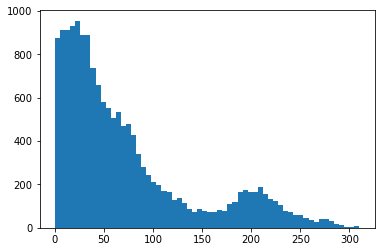

In [25]:
plt.hist(prediction_df['abs_error'], bins=60)

In [ ]:
prediction_df.to_csv("../data/model_training/data/model_predictions/new_models/daily_2022_predictions.csv")

In [ ]:
## Save models!!

normal_training_euro.to_csv("../data/model_training_data/model_predictions/new_models/normal_training_euro.csv")
normal_training.to_csv("../data/model_training_data/model_predictions/new_models/normal_training.csv")
aggressive_training.to_csv("../data/model_training_data/model_predictions/new_models/aggressive_training.csv")
normal_training_euro_low_thresh.to_csv("../data/model_training_data/model_predictions/new_models/normal_training_euro_low_thresh.csv")
normal_training_low_thresh.to_csv("../data/model_training_data/model_predictions/new_models/normal_training_low_thresh.csv")
aggressive_training_low_thresh.to_csv("../data/model_training_data/model_predictions/new_models/aggressive_training_low_thresh.csv")
